## Libraries

In [2]:
pip install pyldavis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive 
import pandas as pd 
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm.notebook import tqdm
from gensim.models.word2vec import Word2Vec
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from collections import OrderedDict

from nltk.corpus import stopwords
import numpy as np
import re
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import pyLDAvis
import pyLDAvis.gensim_models
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import plotly.io as pio
pio.renderers.default = "colab"

stop_words = stopwords.words('english')
stop_words.extend(['admission','date','discharge','birth','sex','f','service','name', 'first', 'call', 'follow', 
                 'patient', 'present', 'illness', 'year', 'day', 'last', 'job', 'number', 'namepattern', 'hospital',
                 'ct', 'addendum', 'lastname', 'firstname', 'l','r', 'x' ])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/tornado/httputil.py:107: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



## Functions

In [4]:
"""
Put a period in the right place in the ICD code.
Generally, procedure codes have dots after the first two digits, while diagnosis codes have dots after the first three digits.
"""
    
def icd_dot(initcode, isdiagcode=False):
    initcode = list(str(initcode))
    icdcode = initcode[:]
    if isdiagcode==False:
        icdcode.insert(2,'.')
    else:
        if initcode[0]=='E':
            if len(initcode)>4:
                icdcode.insert(4,'.')
        else:
            if len(initcode)>3:
                icdcode.insert(3,'.')
    return "".join(icdcode)

In [5]:
"""
Extract Diagnosis terms from NOTEEVENTS TEXT 
It will return flattened list of all words in the full note that are present in discharge diagnosis where words are consists of only alphabets
"""

def diag_token_extract(text):
    rawdiags = re.findall(r"(?<=Diagnos.s:\n)((.+\n)*)(?=)", text)
    rawdiags = [x[0].split('\n')[:-1] for x in rawdiags]
    findiags = [diag.lower().split() for diags in rawdiags for diag in diags if diag != 'Primary Diagnosis:']
    fltdiags = [diag for sublist in findiags for diag in sublist]
    alfdiags = [item for item in fltdiags if item.isalpha()]
    return alfdiags


In [6]:
"""
TEXT from discharge summary to bag of unique words 
"""

def text_to_words(discharge_summary):

    summary = re.sub(r"[^a-zA-Z]", " ", discharge_summary) # Remove special characters and digits

    words = word_tokenize(summary)
    
    # remove stopwords
    filtered_words = [w for w in words if not w.lower() in stop_words]

    # nltk part-of-speech tags
    filtered_words_tagged = nltk.pos_tag(filtered_words)

    # filter for required part of speech   
    filtered_words_new = [x.lower() for (x,y) in filtered_words_tagged if y in ('NN', 'NNS', 'NNP', 'NNS', 'JJ', 'JJS' , 'VBG')]

    filtered_words_new = list(OrderedDict.fromkeys(filtered_words_new))
    
    return filtered_words_new

In [7]:
""" 
Function takes string consisting of ICD 9 codes (abc.xyz format)
Reformats them to abc.x format to improve avg.codes/document density
Outputs a set of reformatted codes
"""

def onelevelup(codes,topicds):

    codes = codes.split(",")

    setofcodes = {''.join(list(code)[:5]) for code in codes}
    setoftopcodes = {''.join(list(code)[:5]) for code in codes if code in topicds}
    return list(setofcodes)#', '.join(setofcodes)


In [8]:
"""
Funtion to train LDA model and get its coherence score
"""


def calc_coherence(tfidf, texts, id2word, n_topics, alpha, eta):

  lda_model = gensim.models.LdaMulticore(corpus=tfidf, id2word=id2word,
                                         num_topics=n_topics, random_state=100, alpha=alpha,
                                         per_word_topics=True, chunksize=10000, passes=5, eta=eta)

  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts,
                                      dictionary=id2word,coherence='c_v')
  
  coherence_lda = coherence_model_lda.get_coherence()

  return coherence_lda

## Gdrive mount

In [9]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Note events dataframe


In [9]:
# discharge summary notes csv read 
df_noteevents=pd.read_csv('gdrive/My Drive/MADS_CourseWork/Milestone 2/mimic-iii-full-data/NOTEEVENTS.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.



In [10]:
#first 10 rows
print(df_noteevents.iloc[:10,10])

# Example of TEXT 
df_noteevents.TEXT[1]


0    Admission Date:  [**2151-7-16**]       Dischar...
1    Admission Date:  [**2118-6-2**]       Discharg...
2    Admission Date:  [**2119-5-4**]              D...
3    Admission Date:  [**2124-7-21**]              ...
4    Admission Date:  [**2162-3-3**]              D...
5    Admission Date:  [**2172-3-5**]              D...
6    Admission Date:  [**2112-12-8**]              ...
7    Admission Date:  [**2150-2-25**]              ...
8    Admission Date:  [**2118-8-10**]              ...
9    Admission Date:  [**2118-12-7**]              ...
Name: TEXT, dtype: object


'Admission Date:  [**2118-6-2**]       Discharge Date:  [**2118-6-14**]\n\nDate of Birth:                    Sex:  F\n\nService:  MICU and then to [**Doctor Last Name **] Medicine\n\nHISTORY OF PRESENT ILLNESS:  This is an 81-year-old female\nwith a history of emphysema (not on home O2), who presents\nwith three days of shortness of breath thought by her primary\ncare doctor to be a COPD flare.  Two days prior to admission,\nshe was started on a prednisone taper and one day prior to\nadmission she required oxygen at home in order to maintain\noxygen saturation greater than 90%.  She has also been on\nlevofloxacin and nebulizers, and was not getting better, and\npresented to the [**Hospital1 18**] Emergency Room.\n\nIn the [**Hospital3 **] Emergency Room, her oxygen saturation was\n100% on CPAP.  She was not able to be weaned off of this\ndespite nebulizer treatment and Solu-Medrol 125 mg IV x2.\n\nReview of systems is negative for the following:  Fevers,\nchills, nausea, vomiting, nigh

In [11]:
# print(df_noteevents.CATEGORY.unique())
df_noteevents['CATEGORY'].value_counts()

Nursing/other        822497
Radiology            522279
Nursing              223556
ECG                  209051
Physician            141624
Discharge summary     59652
Echo                  45794
Respiratory           31739
Nutrition              9418
General                8301
Rehab Services         5431
Social Work            2670
Case Management         967
Pharmacy                103
Consult                  98
Name: CATEGORY, dtype: int64

In [12]:
# A ‘1’ in the ISERROR column indicates that a physician has identified this note as an error.
# dropping these rows from the dataframe
# Only considering discharge summary at this point

print("number of rows that a physician has identified an error = ", len(df_noteevents[df_noteevents.ISERROR == 1]))
df_noteevents_filtered = df_noteevents[(df_noteevents['ISERROR'] != 1)  & (df_noteevents['CATEGORY'] == 'Discharge summary')]
df_noteevents_filtered.info()


#How many unique admissions do we have on filtered events?
print('Number of hospital admissions ? = ', len(df_noteevents_filtered['HADM_ID'].unique()))

number of rows that a physician has identified an error =  886
<class 'pandas.core.frame.DataFrame'>
Int64Index: 59652 entries, 0 to 60415
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ROW_ID       59652 non-null  int64  
 1   SUBJECT_ID   59652 non-null  int64  
 2   HADM_ID      59652 non-null  float64
 3   CHARTDATE    59652 non-null  object 
 4   CHARTTIME    0 non-null      object 
 5   STORETIME    0 non-null      object 
 6   CATEGORY     59652 non-null  object 
 7   DESCRIPTION  59652 non-null  object 
 8   CGID         0 non-null      float64
 9   ISERROR      0 non-null      float64
 10  TEXT         59652 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 5.5+ MB
Number of hospital admissions ? =  52726


### TEXT ANALYSIS On first 200 rows from noteevents dataframe

In [24]:
# Reduced DF from original noteevents df only first 10 rows

# df_noteevents_10rows = pd.read_csv('gdrive/My Drive/MADS_CourseWork/Milestone 2/mimic-iii-full-data/NOTEEVENTS.csv', nrows=10)
# df_noteevents_10rows.to_pickle("gdrive/My Drive/MADS_CourseWork/Milestone 2/mimic-iii-full-data/df_noteevents_10rows.pkl")

df_noteevents_10rows = pd.read_pickle("gdrive/My Drive/MADS_CourseWork/Milestone 2/mimic-iii-full-data/df_noteevents_10rows.pkl") 

In [26]:
df_noteevents_10rows['words'] = df_noteevents_10rows['TEXT'].apply(lambda x: text_to_words(x))

# extracting discharge diagnosis keywords from the TEXT column of noteevents 
df_noteevents_10rows['disch_diagnosis_words'] = df_noteevents_10rows['TEXT'].apply(lambda x: diag_token_extract(x))

# find out which rows have empty list i.e. instances where no diagnosis discharge summary is specified
print(df_noteevents_10rows[df_noteevents_10rows['disch_diagnosis_words'].apply( len ) == 0].index)


# number of words extracted from the complete discharge summary after TEXT preprocessing
df_noteevents_10rows['words_len'] = df_noteevents_10rows['words'].str.len()

# number of words extracted from just the DISCHARGE DIAGNOSIS section of the summary
df_noteevents_10rows['disch_diag_len'] = df_noteevents_10rows['disch_diagnosis_words'].str.len()


# drop rowsfrom df where diag discharge summary is not present  
# df_noteevents_200rows_filt = df_noteevents_200rows[df_noteevents_200rows['disch_diagnosis_words'].map(lambda d: len(d)) > 0]
df_noteevents_10rows_filt = df_noteevents_10rows[df_noteevents_10rows['disch_diag_len'] > 0]

df_noteevents_10rows_filt = df_noteevents_10rows_filt.drop(['DESCRIPTION', 'CHARTTIME','STORETIME',	'CATEGORY', 'DESCRIPTION',	'CGID',	'ISERROR',	'TEXT'], axis=1)
df_noteevents_10rows_filt.head()

Int64Index([0, 1], dtype='int64')


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,words,disch_diagnosis_words,words_len,disch_diag_len
2,176,13702,167118,2119-05-25,"[cardiothoracic, allergies, amlodipine, attend...","[coronary, artery, angina, rca, ef, hiatal, ce...",488,13
3,177,13702,196489,2124-08-18,"[medicine, allergies, amlodipine, attending, l...","[chronic, obstructive, pulmonary, disease, exa...",626,15
4,178,26880,135453,2162-03-25,"[medicine, allergies, known, drugs, attending,...","[cervical, spondylosis, with, calcification, o...",596,16
5,179,53181,170490,2172-03-08,"[neurosurgery, allergies, known, adverse, drug...","[brain, lesion]",344,2
6,180,20646,134727,2112-12-10,"[medicine, allergies, sulfonamides, attending,...",[pneumonia],260,1


In [28]:
CountVec = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
                           stop_words='english')
#transform
noteevents_10rows_filt_sentences = df_noteevents_10rows_filt['disch_diagnosis_words'].apply(lambda x: ' '.join(x))

Count_data = CountVec.fit_transform(noteevents_10rows_filt_sentences)
 
# create feature matrix dataframe with bad of words with only 10 wrows of text
cv_df_noteevents_10rows_filt = pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names())
cv_df_noteevents_10rows_filt
# print(cv_df_noteevents_10rows_filt.sum())


,angina,anxiety,artery,aspiration,avm,brain,calcification,cerebral,cervical,chronic,...,rca,respiratory,rib,sided,skull,spondylosis,ulcer,upper,vascular,vehicle
0,1,0,1,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,1,1
1,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,1,0,0
2,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Combining diagnosis and procedure code

In [ ]:
# df_ALL_codes = pd.concat([df_DIAGNOSES_ICD, df_PROCEDURES_ICD])

# How many unique ICD codes are there ?

# print("Number of unique ICD codes: ", len(df_ALL_codes.ICD9_CODE.unique()))


Number of unique ICD codes:  8994


In [ ]:
# Most common ICDs (ICDs with greater than an occurunce threshold)

# top_50_ICDs = Counter(df_ALL_codes.ICD9_CODE).most_common(50)
# top_50_ICDs

[('401.9', 20703),
 ('38.93', 14731),
 ('428.0', 13111),
 ('427.31', 12891),
 ('414.01', 12429),
 ('96.04', 10333),
 ('96.6', 9300),
 ('584.9', 9119),
 ('96.71', 9100),
 ('250.00', 9058),
 ('272.4', 8690),
 ('518.81', 7497),
 ('99.04', 7244),
 ('39.61', 6838),
 ('599.0', 6555),
 ('530.81', 6326),
 ('96.72', 6048),
 ('272.0', 5930),
 ('99.55', 5842),
 ('V05.3', 5779),
 ('V29.0', 5519),
 ('285.9', 5406),
 ('88.56', 5337),
 ('244.9', 4917),
 ('486', 4839),
 ('38.91', 4737),
 ('285.1', 4552),
 ('276.2', 4528),
 ('496', 4431),
 ('36.15', 4401),
 ('99.15', 4244),
 ('995.92', 3912),
 ('V58.61', 3806),
 ('038.9', 3725),
 ('507.0', 3680),
 ('V30.00', 3566),
 ('88.72', 3548),
 ('585.9', 3435),
 ('311', 3431),
 ('403.90', 3421),
 ('305.1', 3358),
 ('37.22', 3311),
 ('412', 3278),
 ('33.24', 3269),
 ('39.95', 3254),
 ('287.5', 3065),
 ('V45.81', 3056),
 ('410.71', 3055),
 ('276.1', 3039),
 ('424.0', 2926)]

## Combined dataframe with merged columns

In [37]:
# Combining df_DIAGNOSES_ICD  and df_noteevents_filtered dataframe
# df_DIAGNOSES_ICD (labels): sorted by hadm id, contains one label per line
# df_noteevents_filtered (notes as free TEXT): sorted by hadm id, contains one note per line
# Droppped rows for some HADM_ID's that didn't have discharge summaries

print("df_DIAGNOSES_ICD shape is:", df_DIAGNOSES_ICD.shape)


print("df_noteevents filtered shape is:", df_noteevents_filtered.shape)


print('admission IDs without discharge summary = ', len(df_DIAGNOSES_ICD['HADM_ID'].unique()) - len(df_noteevents_filtered['HADM_ID'].unique()))

df_outer_merged = pd.merge(df_noteevents_filtered[['HADM_ID', 'SUBJECT_ID',	'DESCRIPTION', 'TEXT']], 
                           df_DIAGNOSES_ICD[['HADM_ID','SEQ_NUM',	'ICD9_CODE']],
                           how="inner", 
                           on=["HADM_ID"])

print("merged df shape is:", df_outer_merged.shape)
print(df_outer_merged.info())


print('Unique hospital admissions = ', len(df_outer_merged['HADM_ID'].unique()))
df_outer_merged = df_outer_merged.sort_values(['SUBJECT_ID', 'HADM_ID'])
df_outer_merged.head()

df_DIAGNOSES_ICD shape is: (651047, 5)
df_noteevents filtered shape is: (59652, 11)
admission IDs without discharge summary =  6250
merged df shape is: (693821, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 693821 entries, 0 to 693820
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   HADM_ID      693821 non-null  float64
 1   SUBJECT_ID   693821 non-null  int64  
 2   DESCRIPTION  693821 non-null  object 
 3   TEXT         693821 non-null  object 
 4   SEQ_NUM      693815 non-null  float64
 5   ICD9_CODE    693821 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 37.1+ MB
None
Unique hospital admissions =  52726


,HADM_ID,SUBJECT_ID,DESCRIPTION,TEXT,SEQ_NUM,ICD9_CODE
599327,145834.0,3,Report,Admission Date: [**2101-10-20**] Discharg...,1.0,038.9
599328,145834.0,3,Report,Admission Date: [**2101-10-20**] Discharg...,2.0,785.59
599329,145834.0,3,Report,Admission Date: [**2101-10-20**] Discharg...,3.0,584.9
599330,145834.0,3,Report,Admission Date: [**2101-10-20**] Discharg...,4.0,427.5
599331,145834.0,3,Report,Admission Date: [**2101-10-20**] Discharg...,5.0,410.71


In [40]:

df_outer_merged[df_outer_merged['SUBJECT_ID'] == 56174]

,HADM_ID,SUBJECT_ID,DESCRIPTION,TEXT,SEQ_NUM,ICD9_CODE
86,163469.0,56174,Report,Admission Date: [**2118-8-10**] ...,1.0,437.8
87,163469.0,56174,Report,Admission Date: [**2118-8-10**] ...,2.0,747.81
88,163469.0,56174,Report,Admission Date: [**2118-8-10**] ...,3.0,348.5
89,163469.0,56174,Report,Admission Date: [**2118-8-10**] ...,4.0,909.2
90,163469.0,56174,Report,Admission Date: [**2118-8-10**] ...,5.0,345.90
91,189681.0,56174,Report,Admission Date: [**2118-12-7**] ...,1.0,738.19
92,189681.0,56174,Report,Admission Date: [**2118-12-7**] ...,2.0,348.5
93,189681.0,56174,Report,Admission Date: [**2118-12-7**] ...,3.0,345.90
94,189681.0,56174,Report,Admission Date: [**2118-12-7**] ...,4.0,530.81
95,189681.0,56174,Report,Admission Date: [**2118-12-7**] ...,5.0,278.00


In [ ]:
df_outer_merged[df_outer_merged['HADM_ID'] == 189681]


,HADM_ID,SUBJECT_ID,DESCRIPTION,TEXT,SEQ_NUM,ICD9_CODE
91,189681.0,56174,Report,Admission Date: [**2118-12-7**] ...,1.0,738.19
92,189681.0,56174,Report,Admission Date: [**2118-12-7**] ...,2.0,348.5
93,189681.0,56174,Report,Admission Date: [**2118-12-7**] ...,3.0,345.90
94,189681.0,56174,Report,Admission Date: [**2118-12-7**] ...,4.0,530.81
95,189681.0,56174,Report,Admission Date: [**2118-12-7**] ...,5.0,278.00
96,189681.0,56174,Report,Admission Date: [**2118-12-7**] ...,6.0,300.01
97,189681.0,56174,Report,Admission Date: [**2118-12-7**] ...,7.0,909.2
98,189681.0,56174,Report,Admission Date: [**2118-12-7**] ...,8.0,437.8


In [42]:
# Concatenate all the label data with the notes data such that all IDs related to same HADM_ID and SUBJECT_ID are grouped in a single row


df_outer_merged_mod = df_outer_merged

# TODO - GET ICD code number before the period to represent the category 

df_outer_merged_mod['ICDs'] = df_outer_merged_mod[['HADM_ID',
                                                  'SUBJECT_ID','TEXT','ICD9_CODE']].groupby(['SUBJECT_ID','HADM_ID'])['ICD9_CODE'].transform(lambda x: ','.join(x))
# df_outer_merged_mod['Seq_no'] = df_outer_merged_mod.groupby(['SUBJECT_ID','HADM_ID'])['SEQ_NUM'].transform(lambda x: ','.join(str(x)))

# df_outer_merged_mod = df_outer_merged_mod[['SUBJECT_ID','HADM_ID','TEXT']].drop_duplicates()
df_outer_merged_mod = df_outer_merged_mod.drop_duplicates(subset=['SUBJECT_ID','HADM_ID','TEXT'])



In [43]:
# df_outer_merged = pd.DataFrame(None)
df_outer_merged_mod = df_outer_merged_mod.drop(['DESCRIPTION', 'SEQ_NUM', 'ICD9_CODE'], axis=1)
df_outer_merged_mod.head()

,HADM_ID,SUBJECT_ID,TEXT,ICDs
599327,145834.0,3,Admission Date: [**2101-10-20**] Discharg...,"038.9,785.59,584.9,427.5,410.71,428.0,682.6,42..."
63347,185777.0,4,Admission Date: [**2191-3-16**] Discharge...,"042,136.3,799.4,276.3,790.7,571.5,041.11,V09.0..."
287413,107064.0,6,Admission Date: [**2175-5-30**] Dischar...,"403.91,444.0,997.2,276.6,276.7,285.9,275.3,V15.82"
267579,150750.0,9,Admission Date: [**2149-11-9**] Dischar...,"431,507.0,428.0,584.9,276.5,401.9,431,507.0,42..."
267585,150750.0,9,"Name: [**Known lastname 10050**], [**Known fi...","431,507.0,428.0,584.9,276.5,401.9,431,507.0,42..."


In [44]:
df_outer_merged_mod['ICDs'][599327]

'038.9,785.59,584.9,427.5,410.71,428.0,682.6,425.4,263.9'

In [45]:
df_outer_merged_mod['ICDset'] = df_outer_merged_mod['ICDs'].apply(lambda x: onelevelup(x,diag_top_icds))
df_outer_merged_mod['ICDset'].sample(5)

693329    [785.0, V10.0, 403.9, 250.0, V44.3, 424.0, 428...
122094    [416.8, 401.9, 412, V70.7, 440.2, 272.4, 492.8...
36944     [493.2, 425.4, 427.3, 288.0, 242.9, 458.2, 428...
46811     [998.3, 441.9, 532.4, 998.5, 996.7, 570, 263.9...
412580    [401.9, 250.0, 575.1, 276.5, 780.5, 518.8, 534...
Name: ICDset, dtype: object

In [46]:
df_outer_merged_mod['ICDset'][599327]

['425.4',
 '427.5',
 '682.6',
 '038.9',
 '410.7',
 '428.0',
 '263.9',
 '584.9',
 '785.5']

Save dataframe to a pickle file

In [20]:
# df_outer_merged_mod['words'] = df_outer_merged_mod['TEXT'].apply(lambda x: text_to_words(x))
# df_outer_merged_mod.to_pickle("gdrive/My Drive/MADS_CourseWork/Milestone 2/mimic-iii-full-data/dataframe_cleaned_wt_words.pkl")  

cleaned_df = pd.read_pickle("gdrive/My Drive/MADS_CourseWork/Milestone 2/mimic-iii-full-data/dataframe_cleaned_wt_words.pkl")  


In [23]:
cleaned_df['medical_text'] = cleaned_df['words'].apply(lambda x: ' '.join(x))

# number of words extracted from the complete discharge summary after TEXT preprocessing
cleaned_df['words_len'] = cleaned_df['words'].str.len()

cleaned_df


,HADM_ID,SUBJECT_ID,TEXT,ICDs,words,medical_text,words_len
599327,145834.0,3,Admission Date: [**2101-10-20**] Discharg...,"038.9,785.59,584.9,427.5,410.71,428.0,682.6,42...","[medicine, chief, complaint, admitted, rehabil...",medicine chief complaint admitted rehabilitati...,469
63347,185777.0,4,Admission Date: [**2191-3-16**] Discharge...,"042,136.3,799.4,276.3,790.7,571.5,041.11,V09.0...","[chief, complaint, shortness, breath, fevers, ...",chief complaint shortness breath fevers histor...,349
287413,107064.0,6,Admission Date: [**2175-5-30**] Dischar...,"403.91,444.0,997.2,276.6,276.7,285.9,275.3,V15.82","[diagnosis, end, stage, renal, disease, transp...",diagnosis end stage renal disease transplant s...,254
267579,150750.0,9,Admission Date: [**2149-11-9**] Dischar...,"431,507.0,428.0,584.9,276.5,401.9,431,507.0,42...","[neurology, chief, complaint, weakness, inabil...",neurology chief complaint weakness inability t...,315
267585,150750.0,9,"Name: [**Known lastname 10050**], [**Known fi...","431,507.0,428.0,584.9,276.5,401.9,431,507.0,42...","[known, unit, numeric, identifier, mannital, h...",known unit numeric identifier mannital hyperve...,37
...,...,...,...,...,...,...,...
618409,176670.0,99985,Admission Date: [**2181-1-27**] ...,"038.9,518.81,482.41,487.0,785.52,V42.81,995.92...","[medicine, allergies, cefepime, attending, lf,...",medicine allergies cefepime attending lf chief...,489
131172,151118.0,99991,Admission Date: [**2184-12-24**] ...,"562.11,038.9,557.0,584.9,995.92,560.81,789.59,...","[surgery, allergies, known, drugs, attending, ...",surgery allergies known drugs attending lf chi...,432
616809,197084.0,99992,Admission Date: [**2144-7-25**] ...,"999.9,568.81,577.2,285.1,584.9,579.9,729.92,53...","[medicine, allergies, bactrim, norvasc, lipito...",medicine allergies bactrim norvasc lipitor cor...,509
612917,137810.0,99995,Admission Date: [**2147-2-8**] D...,"441.4,428.33,998.12,285.1,424.1,250.00,998.11,...","[surgery, allergies, zantac, attending, lf, ch...",surgery allergies zantac attending lf chief co...,299


In [61]:
# extracting discharge diagnosis keywords from the TEXT column of noteevents 
df_outer_merged_mod['disch_diagnosis_words'] = df_outer_merged_mod['TEXT'].apply(lambda x: diag_token_extract(x))

# find out which rows have empty list i.e. instances where no diagnosis discharge summary is specified
# print(df_outer_merged_mod[df_outer_merged_mod['disch_diagnosis_words'].apply( len ) == 0].index)

# number of words extracted from just the DISCHARGE DIAGNOSIS section of the summary
df_outer_merged_mod['disch_diag_len'] = df_outer_merged_mod['disch_diagnosis_words'].str.len()


# drop rowsfrom df where diag discharge summary is not present  
# df_noteevents_200rows_filt = df_noteevents_200rows[df_noteevents_200rows['disch_diagnosis_words'].map(lambda d: len(d)) > 0]
df_outer_merged_mod = df_outer_merged_mod[df_outer_merged_mod['disch_diag_len'] > 0]

# df_outer_merged_mod

Save dataframe to a pickle file

In [ ]:
# df_outer_merged_mod.to_pickle("gdrive/My Drive/MADS_CourseWork/Milestone 2/mimic-iii-full-data/df_cleaned_wt_only_diagnosis_words.pkl")  

In [10]:
cleaned_diag_df = pd.read_pickle("gdrive/My Drive/MADS_CourseWork/Milestone 2/mimic-iii-full-data/df_cleaned_wt_only_diagnosis_words.pkl")  


In [11]:
cleaned_diag_df['disch_diagnosis_words'] = cleaned_diag_df['disch_diagnosis_words'].apply(lambda x: [w for w in x if not w.lower() in stop_words])
cleaned_diag_df['ICDset_size'] = cleaned_diag_df['ICDset'].str.len()


cleaned_diag_df

,HADM_ID,SUBJECT_ID,TEXT,ICDs,ICDset,disch_diagnosis_words,disch_diag_len,ICDset_size
413856,194540.0,11,Admission Date: [**2178-4-16**] ...,191.3,[191.3],[glioblastoma],1,1
625485,161087.0,17,Admission Date: [**2135-5-9**] D...,"423.9,511.9,785.51,458.9,311,722.0,719.46,272.4","[423.9, 272.4, 458.9, 719.4, 785.5, 311, 511.9...","[emergent, pericardial, window, via, sternotom...",16,8
625481,194023.0,17,Admission Date: [**2134-12-27**] ...,"745.5,458.29,V12.59,272.4","[458.2, 272.4, V12.5, 745.5]","[patent, foramen, ovale, surgical, history, bo...",11,4
119372,188822.0,18,Admission Date: [**2167-9-30**] ...,"250.80,780.39,296.33,V58.67,E932.3,V58.69,478....","[401.9, 272.0, 780.5, V17.0, E932., 780.3, 426...","[axis, mdd, axis, deferred, axis, type, border...",9,12
119385,188822.0,18,Admission Date: [**2167-10-2**] ...,"250.80,780.39,296.33,V58.67,E932.3,V58.69,478....","[401.9, 272.0, 780.5, V17.0, E932., 780.3, 426...","[major, depression, hypoglycemic, seizure, dmi...",6,12
...,...,...,...,...,...,...,...,...
618409,176670.0,99985,Admission Date: [**2181-1-27**] ...,"038.9,518.81,482.41,487.0,785.52,V42.81,995.92...","[272.4, 530.8, 482.4, 238.7, V42.8, 244.9, 785...","[influenza, type, b, severe, mssa, multilobar,...",14,13
131172,151118.0,99991,Admission Date: [**2184-12-24**] ...,"562.11,038.9,557.0,584.9,995.92,560.81,789.59,...","[562.1, V02.5, 560.8, 564.4, 553.8, 719.4, 995...","[recurrent, sepsis, acute, abdomen, internal, ...",15,17
616809,197084.0,99992,Admission Date: [**2144-7-25**] ...,"999.9,568.81,577.2,285.1,584.9,579.9,729.92,53...","[401.9, 530.8, 285.1, 999.9, 272.1, 300.4, 584...","[retroperitoneal, bleed]",2,12
612917,137810.0,99995,Admission Date: [**2147-2-8**] D...,"441.4,428.33,998.12,285.1,424.1,250.00,998.11,...","[440.0, 996.1, 272.4, 285.1, E879., V15.8, V10...","[abdominal, aortic, aneurysm, aortic, stenosis]",5,16


In [12]:
# cleaned_diag_df.to_pickle("gdrive/My Drive/MADS_CourseWork/Milestone 2/mimic-iii-full-data/df_cleaned_wt_only_diagnosis_words_new.pkl")

cleaned_diag_df_new = pd.read_pickle("gdrive/My Drive/MADS_CourseWork/Milestone 2/mimic-iii-full-data/df_cleaned_wt_only_diagnosis_words_new.pkl")  


In [16]:
CountVec = CountVectorizer(ngram_range=(1,1), # to use bigrams ngram_range=(2,2)
                           stop_words='english')

#transform
cleaned_diag_df_sentences = cleaned_diag_df['disch_diagnosis_words'].apply(lambda x: ' '.join(x))

Count_data = CountVec.fit_transform(cleaned_diag_df_sentences)
 
#create dataframe
cv_df_cleaned_diag = pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names_out())


In [17]:
word_count = cv_df_cleaned_diag.sum().sort_values(ascending=False)

print(word_count[:40])


disease           7537
failure           7237
acute             6551
artery            6439
left              5824
hypertension      5788
chronic           5765
coronary          5539
right             5396
renal             4661
atrial            4263
pneumonia         3933
primary           3920
heart             3785
diabetes          3621
secondary         3571
fibrillation      3365
aortic            3333
anemia            3089
fracture          2915
pulmonary         2636
respiratory       2392
type              2234
infection         2147
hyperlipidemia    2085
mellitus          2018
congestive        1989
stenosis          1987
cancer            1867
bleed             1867
urinary           1824
history           1752
valve             1623
hemorrhage        1591
status            1573
htn               1557
myocardial        1546
post              1524
tract             1523
gi                1487
dtype: int64


Analyzing N-grams from words

In [21]:

# Build the bigram and trigram models
bigram = gensim.models.Phrases(words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

NameError: ignored

## Data visulization 

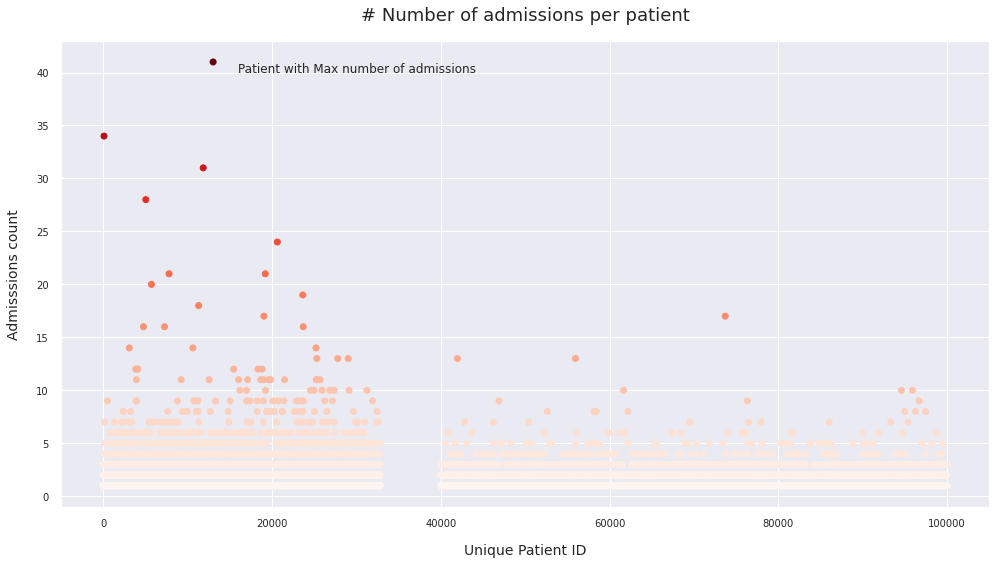

In [ ]:
# Number of admissions per patient 

result = cleaned_df.groupby(['SUBJECT_ID'])['HADM_ID'].nunique().reset_index()
result


plt.figure(figsize=(14, 8))
plt.scatter(result['SUBJECT_ID'], result['HADM_ID'], c=result['HADM_ID'], cmap='Reds', alpha=1)
plt.title("# Number of admissions per patient", fontsize=18, y=1.03)
plt.xlabel("Unique Patient ID", fontsize=14, labelpad=15)
plt.ylabel("Admisssions count", fontsize=14, labelpad=15)
plt.tick_params(labelsize=10, pad=6);
plt.tight_layout()
plt.text(16000,40,"Patient with Max number of admissions")

plt.show()

In [ ]:
# Distribution of length of discharge summary text across all the noteevents documents from unique hospital admissions

cleaned_df['words_len'].iplot(
    kind='hist',
    bins=300,
    xTitle='Discharge diagnosis text length (number of words after stop words)',
    linecolor='black',
    yTitle='Notes count',
    title='Diagnosis text length Distribution')

In [ ]:
# Distribution of number of ICD codes per for unique hospital admissions


cleaned_diag_df['ICDset_size'].iplot(
    kind='hist',
    bins=70,
    xTitle='Number of ICDs per admission',
    linecolor='black',
    yTitle='Notes count',
    title='Distribution of number of ICD codes', color = "lightblue",)

In [ ]:
# Top 50 words in discharge diagnosis summary after removing stop words

word_count[:50].iplot(
    kind='bar',
    xTitle='Words',
    linecolor='black',
    yTitle='Counts',
    title='Top 50 words in discharge diagnosis summary', color = "green",)

## Unsupervised Topic modeling - feature extraction in form of topics

In [24]:
# Base LDA Model from sklearn

tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,1), 
                                   min_df=2,  
                                   max_df=0.95,  
                                   stop_words='english',
                                   max_features = 10000
                                  ) # default English stopwords

tfidf_documents = tfidf_vectorizer.fit_transform(cleaned_df['medical_text'][:1000])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_feature_names[:20]

array(['aa', 'aaa', 'aad', 'aado', 'aao', 'aaox', 'ab', 'abacavir',
       'abcess', 'abd', 'abdomen', 'abdominal', 'abdominial', 'abduct',
       'abduction', 'aberrant', 'abg', 'abgs', 'abi', 'ability'],
      dtype=object)

In [27]:
# Trainig LDA for 20 topics working with first 1000 notes 

lda_first_1000_notes = LatentDirichletAllocation(n_components=20, random_state=0)
lda_first_1000_notes.fit(tfidf_documents)
topic_models = lda_first_1000_notes.components_
# topic_models

In [ ]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [ ]:
# 20 Topic summary
display_topics(lda_first_1000_notes, tfidf_feature_names, 15)

Topic 0:
ended eoms osteal cholangitis univasc luminal catheterizations irregularities ancef pushing late exception ataxic pseudocyst osteo
Topic 1:
content olt valganciclovir rfa refer hcc nonerythematous humulin nonweight neurologist officer orchiectomy cryoglobulinemia ecchymotic mmf
Topic 2:
pleura nonsmall ocular thoracentesis ambien sticks ancef lacrilube dermatologic mongolian photo incompatibility syncytial cooperation subconjunctival
Topic 3:
plasmapheresisis thrombophilic psychiatrist tenofovir pleuritic adenopathy ugib lamivudine little oncology transition paresis ritonavir vl spleen
Topic 4:
immature gallstone necrotizing spleen gcs plexus choroid interim scene inflow read fontanelle ducts cicu laceration
Topic 5:
vp cosyntropin shunt elongated bouts nitrites identifying salt evista scaphoid incontinence controlled intramyocardial plaquenil radiologic
Topic 6:
tibia ends preemie cab truck shallow pg washout comminuted tachypnic atrioseptal mat tub breathsounds hemi
Topic 7:

In [25]:
# implement LDA using gensim for 20 topics working with first 1000 notes 

# Create Dictionary
id2word_first_1000_notes = corpora.Dictionary(cleaned_df['words'][:1000])

# Create Corpus
texts_first_1000_notes = cleaned_df['words'][:1000]

# Term Document Frequency
tfidf_first_1000_notes = [id2word_first_1000_notes.doc2bow(text) for text in texts_first_1000_notes]

# View
print(tfidf_first_1000_notes[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [ ]:
lda_model_first_1000docs = gensim.models.LdaModel(corpus=tfidf_first_1000_notes,
                                                  id2word=id2word_first_1000_notes,
                                                  num_topics=20, 
                                                  random_state=0,
                                                  chunksize=1000,
                                                  passes=5)

In [ ]:
# Print the Keywords in the 20 topics from first 1000 notes 
pprint(lda_model_first_1000docs.print_topics())
doc_lda = lda_model_first_1000docs[tfidf_first_1000_notes]

[(0,
  '0.003*"course" + 0.003*"history" + 0.003*"past" + 0.003*"dr" + '
  '0.003*"allergies" + 0.003*"medications" + 0.002*"stitle" + 0.002*"physical" '
  '+ 0.002*"medical" + 0.002*"mg"'),
 (1,
  '0.002*"bp" + 0.002*"blood" + 0.002*"medications" + 0.002*"course" + '
  '0.002*"allergies" + 0.002*"disposition" + 0.002*"procedure" + '
  '0.002*"followup" + 0.002*"surgical" + 0.002*"attending"'),
 (2,
  '0.002*"history" + 0.002*"past" + 0.002*"mg" + 0.002*"allergies" + '
  '0.002*"physical" + 0.002*"diagnosis" + 0.002*"medical" + 0.002*"course" + '
  '0.002*"chief" + 0.002*"social"'),
 (3,
  '0.002*"physical" + 0.002*"medications" + 0.002*"course" + 0.002*"old" + '
  '0.002*"past" + 0.002*"time" + 0.002*"history" + 0.002*"md" + '
  '0.002*"surgical" + 0.002*"stable"'),
 (4,
  '0.002*"condition" + 0.002*"course" + 0.002*"blood" + 0.002*"mg" + 0.002*"p" '
  '+ 0.002*"medications" + 0.002*"family" + 0.002*"medical" + 0.002*"chief" + '
  '0.002*"medicine"'),
 (5,
  '0.003*"lf" + 0.002*"medic

In [ ]:
# implement LDA using gensim for 20 topics working with all notes 

# Create Dictionary
id2word = corpora.Dictionary(cleaned_diag_df_new['disch_diagnosis_words'])

# Create Corpus
texts = cleaned_diag_df_new['disch_diagnosis_words']

# Term Document Frequency
tfidf = [id2word.doc2bow(text) for text in texts]

# lda_model = gensim.models.LdaModel(corpus=tfidf, id2word=id2word,
#                                    num_topics=20, random_state=100, alpha='auto',
#                                    per_word_topics=True, chunksize=10000, passes=5,
#                                    eval_every = 1, workers=7)

lda_model = gensim.models.LdaMulticore(corpus=tfidf, id2word=id2word,
                                       num_topics=20, random_state=100,
                                       per_word_topics=True, chunksize=10000, passes=5,
                                       eval_every = 1, workers=7)

In [ ]:
# Print the Keywords in the 20 topics from first 1000 notes 
pprint(lda_model.print_topics(20,num_words=15))
doc_lda = lda_model[tfidf]

[(0,
  '0.037*"primary" + 0.036*"hemorrhage" + 0.032*"pneumonia" + 0.026*"artery" + '
  '0.020*"coronary" + 0.018*"failure" + 0.017*"hypertension" + 0.017*"disease" '
  '+ 0.016*"acute" + 0.014*"atrial" + 0.011*"fibrillation" + 0.011*"secondary" '
  '+ 0.011*"renal" + 0.010*"ventricular" + 0.009*"subarachnoid"'),
 (1,
  '0.026*"post" + 0.025*"status" + 0.015*"failure" + 0.014*"left" + '
  '0.012*"pneumonia" + 0.011*"chronic" + 0.011*"right" + 0.010*"thrombosis" + '
  '0.010*"renal" + 0.009*"metastatic" + 0.009*"lower" + 0.009*"respiratory" + '
  '0.008*"deep" + 0.008*"secondary" + 0.008*"gastrointestinal"'),
 (2,
  '0.060*"failure" + 0.056*"heart" + 0.050*"chronic" + 0.043*"acute" + '
  '0.034*"congestive" + 0.034*"diabetes" + 0.033*"disease" + 0.025*"renal" + '
  '0.024*"type" + 0.023*"mellitus" + 0.022*"systolic" + 0.019*"secondary" + '
  '0.018*"hypertension" + 0.017*"artery" + 0.016*"diastolic"'),
 (3,
  '0.031*"cad" + 0.023*"acute" + 0.023*"renal" + 0.021*"htn" + 0.017*"failure" '

In [29]:
topic_word_df = pd.DataFrame([[word for rank, (word, prob) in enumerate(words)] 
                              for topic_id, words in lda_model.show_topics(formatted=False, num_words=15, num_topics=20)])
topic_word_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,primary,secondary,pneumonia,diagnosis,artery,hemorrhage,acute,coronary,disease,hypertension,anemia,pulmonary,cardiac,loss,blood
1,aortic,valve,mitral,replacement,disease,hypertension,stenosis,history,left,chronic,regurgitation,repair,right,renal,artery
2,failure,acute,renal,heart,chronic,pneumonia,respiratory,anemia,congestive,liver,systolic,cirrhosis,atrial,shock,hypertension
3,artery,coronary,disease,hypertension,bypass,graft,diabetes,left,hyperlipidemia,atrial,aortic,stenosis,right,mellitus,fibrillation
4,urinary,infection,tract,diabetes,pneumonia,type,primary,secondary,mellitus,hypertension,chronic,bacteremia,acute,failure,anemia
5,failure,respiratory,pneumonia,heart,cervical,block,associated,hypertension,complete,aspiration,pulmonary,arrest,stenosis,disease,induced
6,acute,chronic,bleed,anemia,gi,blood,pneumonia,injury,loss,sepsis,secondary,failure,kidney,pulmonary,primary
7,disease,hernia,history,chronic,artery,renal,right,postop,coronary,htn,cabg,repair,hypertension,cad,pulmonary
8,secondary,esophageal,hypertension,primary,ulcer,pneumonia,cancer,chronic,diabetes,varices,uti,cirrhosis,infection,type,renal
9,status,post,cad,left,htn,hyperlipidemia,right,hypertension,cabg,atrial,diabetes,traumatic,gi,injury,bilateral


Evaluating topic models from LDA with coherence score


In [30]:
"""
While evaluation methods based on human judgment can produce good results, they are costly and time-consuming to do.
For this study we are going to use some of the quantitative metrics learnt in class to evaluate our topics
This also enables us to standardize, automate and scale the evaluation of topic models.
"""

# Compute Coherence Score first_1000_notes
coherence_model_lda_first_1000_notes = CoherenceModel(model=lda_model_first_1000docs, texts=texts_first_1000_notes,
                                     dictionary=id2word_first_1000_notes,coherence='c_v')
coherence_lda_first_1000_notes = coherence_model_lda_first_1000_notes.get_coherence()
print('\nCoherence Score LDA first 1000 notes: ', coherence_lda_first_1000_notes)


Coherence Score LDA first 1000 notes:  0.3819425020120804


In [ ]:
# Compute Coherence Score with all notes considered
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts,
                                     dictionary=id2word,coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score LDA with all notes: ', coherence_lda)


Coherence Score LDA with all notes:  0.5351518109513002


Unsupervised LDA model hyper parameter tuning

In [ ]:
# calc_coherence(tfidf, texts, id2word, n_topics, alpha, eta)

In [ ]:
# Topic model eval - num of topics and hyper parameter tuning
  # iterate through number of topics
  # iterate through alpha values
  # iterare through eta values
  # calculate the coherence score for the given parameters

num_topics_sel = range(10, 40, 10)
alpha_sel = list(np.arange(0.01, 1, 0.3))
eta_sel = list(np.arange(0.01, 1, 0.3))

df_coherence_score = pd.DataFrame(columns=['Num_topics','Alpha','Eta', 'Coh_Score'])
num_topics = []
alpha_value = []
eta_value = []
coh_score = []
i=0
s=0

for n_topics in num_topics_sel:
  for alpha in alpha_sel:
    for eta in eta_sel:
      s += 1
      num_topics.append(n_topics)
      alpha_value.append(alpha)
      eta_value.append(eta)
      score = calc_coherence(tfidf, texts, id2word, n_topics, alpha, eta)
      coh_score.append(score)

df_coherence_score = pd.DataFrame({'Num_topics': num_topics, 'Alpha': alpha_value, 'Eta': eta_value, 'Coh_Score': coh_score})


df_coherence_score.head()

In [ ]:
# df_coherence_score.to_pickle("gdrive/My Drive/MADS_CourseWork/Milestone 2/mimic-iii-full-data/df_coherence_score.pkl")
df_coherence_score

,Num_topics,Alpha,Eta,Coh_Score
0,10,0.01,0.01,0.564869
1,10,0.01,0.31,0.561673
2,10,0.01,0.61,0.547790
3,10,0.01,0.91,0.583631
4,10,0.31,0.01,0.543548
5,10,0.31,0.31,0.542996
6,10,0.31,0.61,0.530559
7,10,0.31,0.91,0.535257
8,10,0.61,0.01,0.526823
9,10,0.61,0.31,0.528655


In [ ]:
print('Hyper paramerters with max coherence score: \n ', df_coherence_score[df_coherence_score.Coh_Score == df_coherence_score.Coh_Score.max()])

Hyper paramerters with max coherence score: 
     Num_topics  Alpha   Eta  Coh_Score
3          10   0.01  0.91   0.583631


Determining optimum number of topics, alpha, eta value based on coherence score

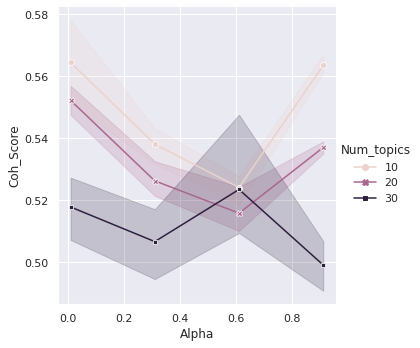

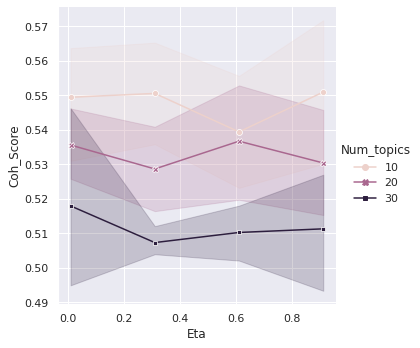

In [ ]:
# df_coherence_score = pd.DataFrame(columns=['Num_topics','Alpha','Eta'])
# sns.set(rc={"figure.figsize":(15, 10)})

sns.relplot(data=df_coherence_score, kind="line", 
            x="Alpha", y="Coh_Score", hue="Num_topics", style="Num_topics",
            dashes=False, markers=True)
sns.relplot(data=df_coherence_score, kind="line", 
            x="Eta", y="Coh_Score", hue="Num_topics", style="Num_topics",
            dashes=False, markers=True)

In [ ]:
lda_model_final = gensim.models.LdaMulticore(corpus=tfidf, id2word=id2word,
                                       num_topics=10, random_state=100, alpha = 0.01, eta=0.91,
                                       per_word_topics=True, chunksize=10000, passes=5,
                                       eval_every = 1, workers=7)

topic_word_df_final = pd.DataFrame([[word for rank, (word, prob) in enumerate(words)] 
                              for topic_id, words in lda_model_final.show_topics(formatted=False, num_words=15, num_topics=20)])
topic_word_df_final

In [32]:
# Visualize the topics with LDAVis library first 1000 notes

pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, tfidf, id2word)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.212009  0.102892       1        1  12.611930
10     0.033638  0.125747       2        1   9.713313
2      0.127532  0.041834       3        1   8.031729
13    -0.117098 -0.260897       4        1   7.834800
1     -0.098533  0.077942       5        1   6.766509
11     0.052155 -0.034269       6        1   5.456114
4      0.092176  0.037477       7        1   5.181064
9     -0.058965 -0.059650       8        1   4.197374
8      0.072062  0.021532       9        1   4.084973
7     -0.081670  0.059084      10        1   3.845961
6      0.099562 -0.003863      11        1   3.809858
18     0.140836  0.026177      12        1   3.655107
15     0.105636 -0.112502      13        1   3.485011
17    -0.096277 -0.012529      14        1   3.408140
12     0.021859 -0.031041      15        1   3.156348
0      0.004979 -0.000041      16        1   3.052246
19    -0.032431 -0.036878      17        1   3.017104
5      0.038498  0.032803      18        1   2.978766
14     0.002947 -0.045499      19        1   2.905928
16    -0.094898  0.071683      20        1   2.807725, topic_info=          Term         Freq        Total Category  logprob  loglift
36    fracture  3021.000000  3021.000000  Default  30.0000  30.0000
42     failure  7137.000000  7137.000000  Default  29.0000  29.0000
40    coronary  5693.000000  5693.000000  Default  28.0000  28.0000
65      artery  6580.000000  6580.000000  Default  27.0000  27.0000
37       acute  6215.000000  6215.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
202  secondary    72.015210  3277.573633  Topic20  -5.0701  -0.2452
125    primary    71.425357  3484.420961  Topic20  -5.0783  -0.3146
77    stenosis    63.079629  1954.313075  Topic20  -5.2026   0.1394
37       acute    61.785761  6215.680042  Topic20  -5.2233  -1.0384
43       heart    58.996714  3807.889664  Topic20  -5.2695  -0.5946

[1615 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1039      1  0.055536        aaa
1039      2  0.022215        aaa
1039      3  0.038875        aaa
1039      4  0.027768        aaa
1039      5  0.066644        aaa
...     ...       ...        ...
1132      4  0.841969  zygomatic
1132      5  0.026312  zygomatic
1132      8  0.026312  zygomatic
1132     14  0.026312  zygomatic
1132     16  0.026312  zygomatic

[9639 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 11, 3, 14, 2, 12, 5, 10, 9, 8, 7, 19, 16, 18, 13, 1, 20, 6, 15, 17])

In [ ]:
# implement LSI using gensim 

lsi_model_first_1000docs = gensim.models.LsiModel(corpus=tfidf,id2word=id2word,
                                                  num_topics=20, chunksize=1000)

lsi_model_first_1000docs.show_topics(num_topics=20)


[(0,
  '0.098*"history" + 0.097*"medications" + 0.097*"course" + 0.095*"physical" + 0.091*"medical" + 0.091*"mg" + 0.089*"blood" + 0.089*"condition" + 0.089*"past" + 0.085*"allergies"'),
 (1,
  '-0.159*"medquist" + -0.159*"dictated" + -0.115*"hematocrit" + -0.113*"examination" + -0.105*"rate" + -0.104*"md" + -0.103*"old" + -0.096*"white" + 0.091*"attending" + 0.090*"major"'),
 (2,
  '-0.097*"coronary" + -0.097*"aspirin" + -0.088*"artery" + 0.086*"sepsis" + 0.084*"infant" + 0.084*"life" + 0.082*"infectious" + -0.081*"catheterization" + 0.081*"immunizations" + 0.080*"delivery"'),
 (3,
  '0.081*"cardiothoracic" + 0.081*"aspirin" + 0.079*"weeks" + 0.074*"known" + -0.073*"secondary" + 0.070*"coronary" + 0.070*"dr" + -0.068*"baseline" + -0.066*"urine" + 0.066*"bypass"'),
 (4,
  '-0.120*"ventricular" + -0.118*"mitral" + -0.117*"regurgitation" + -0.111*"function" + -0.107*"aortic" + -0.104*"systolic" + -0.104*"leaflets" + -0.102*"cavity" + -0.101*"valve" + -0.094*"size"'),
 (5,
  '-0.087*"tube

In [ ]:
coherence_model_lsi = CoherenceModel(model=lsi_model_first_1000docs, texts=texts,
                                     dictionary=id2word,coherence='c_v')

coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score LSI: ', coherence_lsi)


Coherence Score LSI:  0.44575265112067797


In [ ]:
# get document topics. A list comprehension on that to find the probability distribution of the topics for a specific discharge summary 

for i in range(len(texts[:2])):
      print(texts.iloc[i])
      top_topics = lda_model.get_document_topics(tfidf[i], minimum_probability=0.0)
      print(top_topics)

      topic_vec = [top_topics[i][1] for i in range(20)]
      print(topic_vec)


['glioblastoma']
[(0, 0.025), (1, 0.025), (2, 0.025), (3, 0.025), (4, 0.025), (5, 0.025), (6, 0.025), (7, 0.525), (8, 0.025), (9, 0.025), (10, 0.025), (11, 0.025), (12, 0.025), (13, 0.025), (14, 0.025), (15, 0.025), (16, 0.025), (17, 0.025), (18, 0.025), (19, 0.025)]
[0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.525, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
['emergent', 'pericardial', 'window', 'via', 'sternotomy', 'cardiogenic', 'min', 'pfo', 'closure', 'cva', 'cervical', 'disc', 'herniation', 'syndrome', 'borderline', 'hyperlipidemia']
[(0, 0.29690835), (1, 0.44223794), (2, 0.0029411763), (3, 0.0029411763), (4, 0.0029411763), (5, 0.0029411763), (6, 0.0029411763), (7, 0.21085367), (8, 0.0029411763), (9, 0.0029411763), (10, 0.0029411763), (11, 0.0029411763), (12, 0.0029411763), (13, 0.0029411763), (14, 0.0029411763), (15, 0.0029411763), (16, 0.0029411763), (17, 0.0029411763), (18, 0.0029411763), (19, 0.0029411763)]
[0.29690835, 0.4422379

In [ ]:
# probability distribution of topics

cleaned_diag_df['prob_dist_topics'] = lda_model.get_document_topics(tfidf, minimum_probability=0.0)

cleaned_diag_df['prob_dist_topics'] = cleaned_diag_df['prob_dist_topics'].apply(lambda x: [x[i][1] for i in range(20)])

# cleaned_diag_df['prob_dist_topics'] = [top_topics[i][1] for i in range(20)]


In [ ]:
cleaned_diag_df

,HADM_ID,SUBJECT_ID,TEXT,ICDs,ICDset,disch_diagnosis_words,disch_diag_len,prob_dist_topics
413856,194540.0,11,Admission Date: [**2178-4-16**] ...,191.3,[191.3],[glioblastoma],1,"[0.025000002, 0.025000002, 0.025000002, 0.0250..."
625485,161087.0,17,Admission Date: [**2135-5-9**] D...,"423.9,511.9,785.51,458.9,311,722.0,719.46,272.4","[423.9, 272.4, 458.9, 719.4, 785.5, 311, 511.9...","[emergent, pericardial, window, via, sternotom...",16,"[0.29949427, 0.44043154, 0.0029411765, 0.00294..."
625481,194023.0,17,Admission Date: [**2134-12-27**] ...,"745.5,458.29,V12.59,272.4","[458.2, 272.4, V12.5, 745.5]","[patent, foramen, ovale, surgical, history, of...",11,"[0.6565966, 0.10479311, 0.004166667, 0.0041666..."
119372,188822.0,18,Admission Date: [**2167-9-30**] ...,"250.80,780.39,296.33,V58.67,E932.3,V58.69,478....","[401.9, 272.0, 780.5, V17.0, E932., 780.3, 426...","[axis, mdd, axis, deferred, axis, type, border...",9,"[0.71092135, 0.005, 0.005, 0.005, 0.005, 0.005..."
119385,188822.0,18,Admission Date: [**2167-10-2**] ...,"250.80,780.39,296.33,V58.67,E932.3,V58.69,478....","[401.9, 272.0, 780.5, V17.0, E932., 780.3, 426...","[major, depression, hypoglycemic, seizure, dmi...",6,"[0.007142857, 0.007142857, 0.007142857, 0.0071..."
...,...,...,...,...,...,...,...,...
618409,176670.0,99985,Admission Date: [**2181-1-27**] ...,"038.9,518.81,482.41,487.0,785.52,V42.81,995.92...","[272.4, 530.8, 482.4, 238.7, V42.8, 244.9, 785...","[influenza, type, b, severe, mssa, multilobar,...",14,"[0.0033333336, 0.0033333336, 0.0033333336, 0.0..."
131172,151118.0,99991,Admission Date: [**2184-12-24**] ...,"562.11,038.9,557.0,584.9,995.92,560.81,789.59,...","[562.1, V02.5, 560.8, 564.4, 553.8, 719.4, 995...","[recurrent, sepsis, with, acute, abdomen, and,...",15,"[0.003125, 0.003125, 0.22383532, 0.003125, 0.0..."
616809,197084.0,99992,Admission Date: [**2144-7-25**] ...,"999.9,568.81,577.2,285.1,584.9,579.9,729.92,53...","[401.9, 530.8, 285.1, 999.9, 272.1, 300.4, 584...","[retroperitoneal, bleed]",2,"[0.016666668, 0.016666668, 0.016666668, 0.0166..."
612917,137810.0,99995,Admission Date: [**2147-2-8**] D...,"441.4,428.33,998.12,285.1,424.1,250.00,998.11,...","[440.0, 996.1, 272.4, 285.1, E879., V15.8, V10...","[abdominal, aortic, aneurysm, aortic, stenosis]",5,"[0.8416667, 0.008333333, 0.008333333, 0.008333..."


In [ ]:
# cleaned_diag_df.to_pickle("gdrive/My Drive/MADS_CourseWork/Milestone 2/mimic-iii-full-data/df_cleaned_wt_prob_topic_dist.pkl")  

## Supervised Learning

Functions

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import f1_score, accuracy_score
# from skmultilearn.problem_transform import BinaryRelevance
import xgboost as xgb

In [ ]:
def diag_token_extract(text):
    rawdiags = re.findall(r"(?<=Diagnos.s:\n)((.+\n)*)(?=)", text)
    rawdiags = [x[0].split('\n')[:-1] for x in rawdiags]
    findiags = [diag.lower().split() for diags in rawdiags for diag in diags if diag != 'Primary Diagnosis:']
    fltdiags = [diag for sublist in findiags for diag in sublist]
    alfdiags = [item for item in fltdiags if item.isalpha()]
    return alfdiags

#_____________________________________________________________
# Insert missing "." in ICD codes
def icd_dot(initcode, isdiagcode=False):
    initcode = list(str(initcode))
    icdcode = initcode[:]
    if isdiagcode==False:
        icdcode.insert(2,'.')
    else:
        if initcode[0]=='E':
            if len(initcode)>4:
                icdcode.insert(4,'.')
        else:
            if len(initcode)>3:
                icdcode.insert(3,'.')
        icdcode=icdcode[:5]
    return "".join(icdcode)

#_____________________________________________________________
def onelevelup(codes,topicds):
    # Function takes string consisting of ICD 9 codes (abc.xyz format)
    # Reformats them to abc.x format to improve avg.codes/document density
    # Outputs a set of reformatted codes
    codes = codes.split(",")
    setofcodes = {''.join(list(code)[:5]) for code in codes if code in topicds}
    return list(setofcodes)#', '.join(setofcodes)
#_____________________________________________________________
def dataprep(df, diagicd_df, mostcommon=50):
    topicds=Counter(diagicd_df.ICD_CODE).most_common(mostcommon)
    topicds = [icd[0] for icd in topicds]
    df['ICDset'] = df['ICDs'].apply(lambda x: onelevelup(x, topicds))
    df['Tokens'] = df['TEXT'].apply(lambda x: diag_token_extract(x))

    df = df[df['Tokens'].map(lambda d: len(d)) > 0]
    df = df[df['ICDset'].map(lambda d: len(d)) > 0]

    print("Shape of the dataset = ",df.shape)
    print("Number of Unique set of ICDs = ", df['ICDset'].astype(str).nunique())

    # Transforming prediction target 'y'
    y = df['ICDset']
    mlb = MultiLabelBinarizer()
    y_ = mlb.fit_transform(y)

    x_train, x_test, ytrain, ytest = train_test_split(df['Tokens'],
                                              y_, test_size=0.2)

    return x_train, x_test, ytrain, ytest